Логистическая регрессия
==================

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Хотим попробовать применить ту же модель линейной регрессии, но для задачи классификации. То есть
$$\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik} = y_i,$$
где $X_i = (x_{i1}, \ldots, x_{ik})$ -- строка с данными, $y_i\in\{0, 1\}$, $\beta_0, \ldots, \beta_k$ -- неизвестные коэффициенты.
Проблема в том, что слева стоит непрерывная функция по $x$, а справа -- дискретная переменная. Кроме того, при больших значениях $x$ функция слева будет гарантированно давать большие значения. Так что применить модель прямо в таком виде -- плохая идея.

Введём логистическую функцию (сигмоид) $\sigma(x)=\frac{1}{1+e^{-x}}$.

Text(0.5, 1.0, 'Логистическая функция')

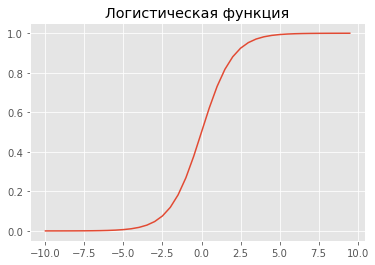

In [2]:
x = np.array(np.arange(-10, 10, 0.5))
y = 1. / (1 + np.exp(-x))
plt.plot(x, y)
plt.title(u'Логистическая функция')

Заметим, что $\sigma: \mathbb{R}\rightarrow (0, 1)$.

Применим к левой части логистическую функцию и будем решать задачу в виде
$$\sigma\left(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik}\right) = y_i.$$

Теперь слева у нас всегда будут получаться значения из $(0, 1)$, и это можно интерпретировать как вероятности принадлежности классу: если меньше 0.5, то класс 0, иначе -- класс 1.

Но теперь у нас пропадает аналитическое решение, которое было для линейной регрессии. Теперь придётся решать задачу оптимизации. Градиентный спуск (или другие методы) в помощь!

### Пример. Предсказание депозита. 


In [7]:
df = pd.read_csv('bank-full.csv', sep=';')

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
df.shape

(45211, 17)

In [10]:
df = df.dropna()

Кроме обычных, пропущенных пропущенные значения числятся как 'unknown'. Посмотрим, как они распределены по колонкам.

In [6]:
df.shape

(45211, 17)

In [11]:
df.apply(lambda x: sum(x == 'unknown'), axis=0)

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

Выбросим колонки ```contact```, ```poutcome```, ```duration``` полностью, и выбросим строчки с пропущенными значениями в колонках ```job``` и ```education```.

In [12]:
df = df.drop(['contact', 'poutcome'], axis=1)
df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]
df.shape


(43193, 15)

Заметим, что колонка ```education``` имеет естественный порядок, а колонки ```default```, ```housing``` и ```loan``` -- бинарные. Преобразуем их в численные. Колонку ```y``` тоже, само собой.

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no
5,35,management,married,tertiary,no,231,yes,no,5,may,139,1,-1,0,no
6,28,management,single,tertiary,no,447,yes,yes,5,may,217,1,-1,0,no


In [15]:
print (df['education'].value_counts())
print (df['default'].value_counts())
print (df['housing'].value_counts())
print (df['loan'].value_counts())
print (df['y'].value_counts())

secondary    23131
tertiary     13262
primary       6800
Name: education, dtype: int64
no     42411
yes      782
Name: default, dtype: int64
yes    24292
no     18901
Name: housing, dtype: int64
no     36086
yes     7107
Name: loan, dtype: int64
no     38172
yes     5021
Name: y, dtype: int64


In [16]:
print (df['job'].value_counts())

blue-collar      9278
management       9216
technician       7355
admin.           5000
services         4004
retired          2145
self-employed    1540
entrepreneur     1411
unemployed       1274
housemaid        1195
student           775
Name: job, dtype: int64


In [17]:
df['education'] = df['education'].map({'primary': 0, 'secondary': 1, 'tertiary': 2})
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['y'] = df['y'].map({'no': 0, 'yes': 1})

Категориальные колонки ```job```, ```marital```, ```month``` не имеют естественного порядка, поэтому преобразуем их с помощью one-hot encoding.

In [18]:
cat_features = ['job', 'marital', 'month']
df = pd.get_dummies(df, columns=cat_features)

Выбросим колонку-отклик и соберём все данные в матрицу X.

In [19]:
X = df.drop('y', axis=1)
y = df['y']

In [20]:
X.shape

(43193, 37)

In [21]:
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,2,0,2143,1,0,5,261,1,-1,...,0,0,0,0,0,0,1,0,0,0
1,44,1,0,29,1,0,5,151,1,-1,...,0,0,0,0,0,0,1,0,0,0
2,33,1,0,2,1,1,5,76,1,-1,...,0,0,0,0,0,0,1,0,0,0
5,35,2,0,231,1,0,5,139,1,-1,...,0,0,0,0,0,0,1,0,0,0
6,28,2,0,447,1,1,5,217,1,-1,...,0,0,0,0,0,0,1,0,0,0


Логистическая модель в sklearn реализована в классе ```LogisticRegression``` библиотеки ```linear_model```.

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    # метод для поиска решения. Для небольших датасетов лучше подходит liblinear, sag и saga -- для больших.
    # Варианты: newton-cg, lbfgs, liblinear, sag, saga
    solver='liblinear',
    # норма для регуляризации. Варианты: l2, l1.
    penalty='l2',
    # параметр регуляризации. Чем меньше, тем сильнее регуляризация. Положительный.
    C=1,
    # параметр для остановки поиска решения.
    tol=1e-4,
    # Так как распознается 2 класса.
    multi_class='ovr'
    )

In [23]:
model.fit(X, y)

LogisticRegression(C=1, multi_class='ovr', solver='liblinear')

In [24]:
preds = model.predict(X)

In [25]:
preds

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [26]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y, preds)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,37305,867
1,3681,1340


In [27]:
pred_prob = model.predict_proba(X)

In [29]:
pred_prob

array([[0.95939191, 0.04060809],
       [0.97131597, 0.02868403],
       [0.99246148, 0.00753852],
       ...,
       [0.13192178, 0.86807822],
       [0.86843554, 0.13156446],
       [0.73995439, 0.26004561]])

In [28]:
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)


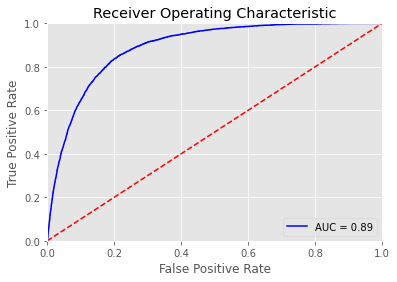

In [30]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score

In [32]:
precision_score(y, model.predict(X))

0.6071590394200271

In [33]:
recall_score(y, model.predict(X))

0.26687910774746065

In [ ]:
###############

In [34]:
import seaborn as sns

In [35]:
microchip = pd.read_csv(
    'microchip_test.csv',
    names=['Test1', 'Test2', 'Passed'],
)

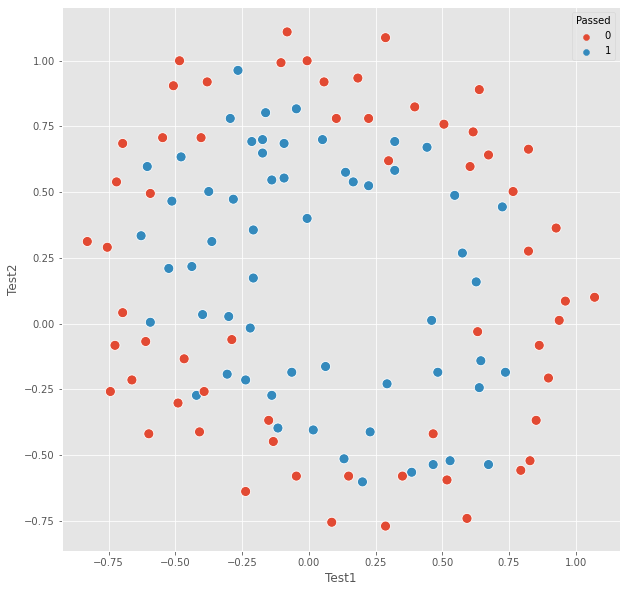

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

sns.scatterplot(x='Test1', y='Test2', hue='Passed', data=microchip, s=100);

Text(0, 0.5, 'Feature 1')

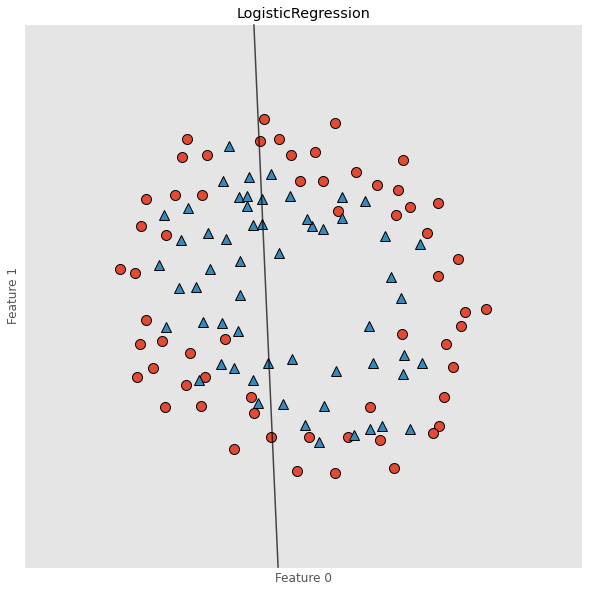

In [37]:
from sklearn.linear_model import LogisticRegression
import mglearn

X, y = microchip[['Test1','Test2']], microchip['Passed']

fig, axes = plt.subplots(1, 1, figsize=(10, 10))

model = LogisticRegression()
ax = axes
clf = model.fit(X, y)
mglearn.plots.plot_2d_separator(clf, X.values, fill=False, eps=0.5,
                                ax=ax, alpha=.7)
mglearn.discrete_scatter(X[['Test1']].values, X[['Test2']].values, y, ax=ax)
ax.set_title(clf.__class__.__name__)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")

In [44]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(
                          degree=7,
                          include_bias=False,
                        )
X0 = poly.fit_transform(microchip[['Test1', 'Test2']])

In [45]:
poly.get_feature_names(['Test1', 'Test2'])

['Test1',
 'Test2',
 'Test1^2',
 'Test1 Test2',
 'Test2^2',
 'Test1^3',
 'Test1^2 Test2',
 'Test1 Test2^2',
 'Test2^3',
 'Test1^4',
 'Test1^3 Test2',
 'Test1^2 Test2^2',
 'Test1 Test2^3',
 'Test2^4',
 'Test1^5',
 'Test1^4 Test2',
 'Test1^3 Test2^2',
 'Test1^2 Test2^3',
 'Test1 Test2^4',
 'Test2^5',
 'Test1^6',
 'Test1^5 Test2',
 'Test1^4 Test2^2',
 'Test1^3 Test2^3',
 'Test1^2 Test2^4',
 'Test1 Test2^5',
 'Test2^6',
 'Test1^7',
 'Test1^6 Test2',
 'Test1^5 Test2^2',
 'Test1^4 Test2^3',
 'Test1^3 Test2^4',
 'Test1^2 Test2^5',
 'Test1 Test2^6',
 'Test2^7']

In [46]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [47]:
model = LogisticRegression()
ax = axes
clf = model.fit(X0, y)
clf.score(X0, y)

0.8305084745762712

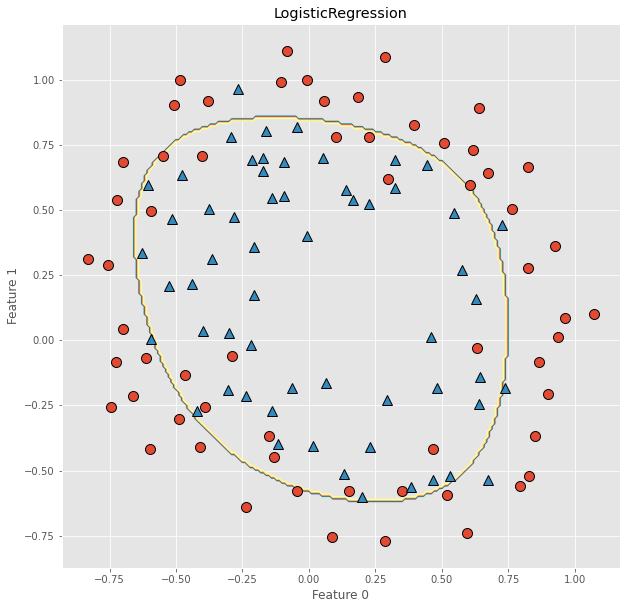

In [48]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

ax = axes
mglearn.discrete_scatter(X[['Test1']].values, X[['Test2']].values, y, ax=ax)
ax.set_title(clf.__class__.__name__)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
plot_boundary(clf, X[['Test1','Test2']].values, y, grid_step=.01, poly_featurizer=poly)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


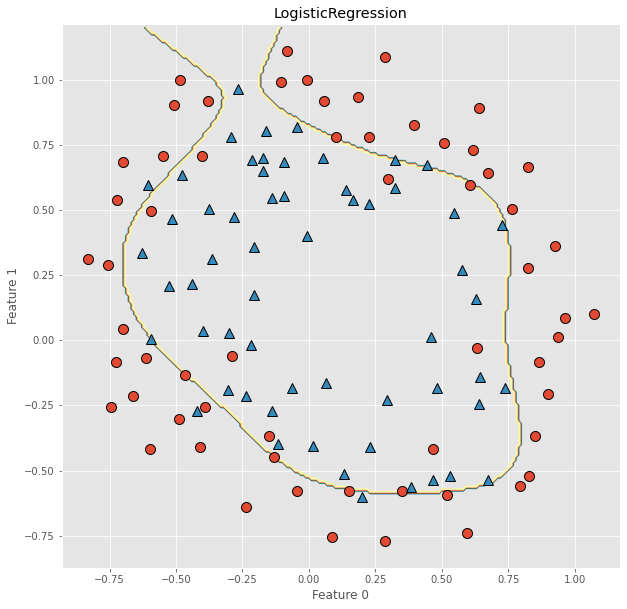

In [56]:
model = LogisticRegression(C = 1e4)
ax = axes
clf = model.fit(X0, y)
clf.score(X0, y)
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

ax = axes
mglearn.discrete_scatter(X[['Test1']].values, X[['Test2']].values, y, ax=ax)
ax.set_title(clf.__class__.__name__)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
plot_boundary(clf, X[['Test1','Test2']].values, y, grid_step=.01, poly_featurizer=poly)

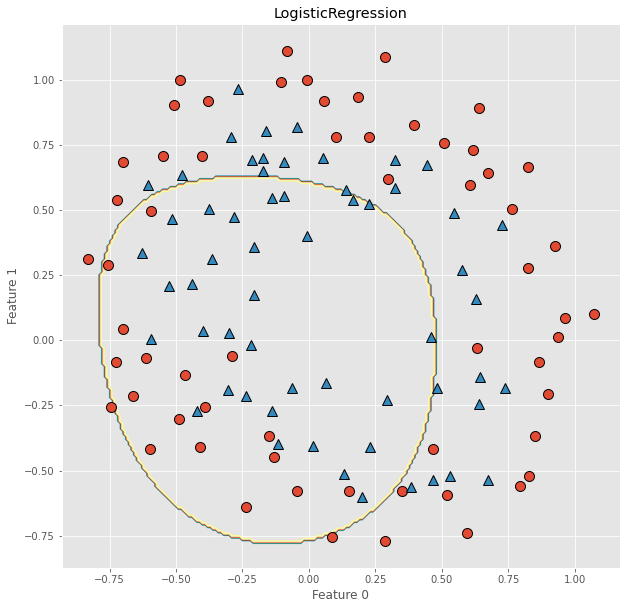

In [50]:
model = LogisticRegression(C = 1e-2)
ax = axes
clf = model.fit(X0, y)
clf.score(X0, y)
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

ax = axes
mglearn.discrete_scatter(X[['Test1']].values, X[['Test2']].values, y, ax=ax)
ax.set_title(clf.__class__.__name__)
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
plot_boundary(clf, X[['Test1','Test2']].values, y, grid_step=.01, poly_featurizer=poly)